# 0.0. IMPORTS

In [59]:
import inflection
import math
import datetime


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy                        import stats as ss
from IPython.core.display         import HTML
from IPython.display              import Image
from matplotlib.gridspec          import GridSpec
from sklearn.preprocessing        import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr=max(0, (chi2-((k-1)*(r-1)/(n-1))))

    k_corr= (k-((k-1)**2)/(n-1))
    r_corr =(r-((r-1)**2)/(n-1))

    return np.sqrt((chi2_corr/n)/min(k_corr-1, r_corr-1))

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

In [4]:
#merge:
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on= 'Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
452027,123,4,2014-05-22,8310,949,1,1,0,0,a,a,16760.0,9.0,2011.0,0,NaN,NaN,NaN


# 1.0. DESCRIÇÃO DE DADOS

## 1.1. Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimension

In [7]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Collumns: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Collumns: 18


## 1.3. Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
              
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)



In [12]:
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'May', 5: 'Apr', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis =1)

In [13]:
df1.sample(5).T

,915546,664369,509920,456880,505019
store,917,615,36,516,710
day_of_week,2,3,1,7,6
date,2013-04-02 00:00:00,2013-11-13 00:00:00,2014-03-31 00:00:00,2014-05-18 00:00:00,2014-04-05 00:00:00
sales,7207,8138,11182,0,4905
customers,840,1153,1285,0,432
open,1,1,1,0,1
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,a,d,a,a,d


## 1.6 Change types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical 

In [17]:
num_attributes = df1.select_dtypes (include=['int64', 'float64'])
cat_attributes = df1.select_dtypes (exclude= ['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [18]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max,range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


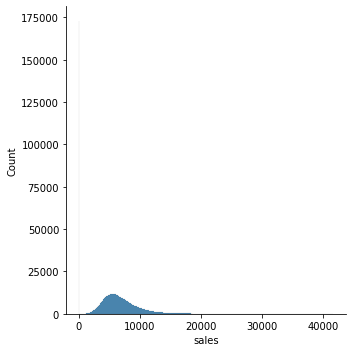

In [19]:
sns.displot(df1['sales'])

## 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

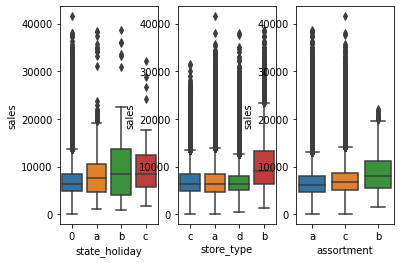

In [21]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. FEATURE ENGINEERING

## 2.1. Mapa mental de Hipóteses

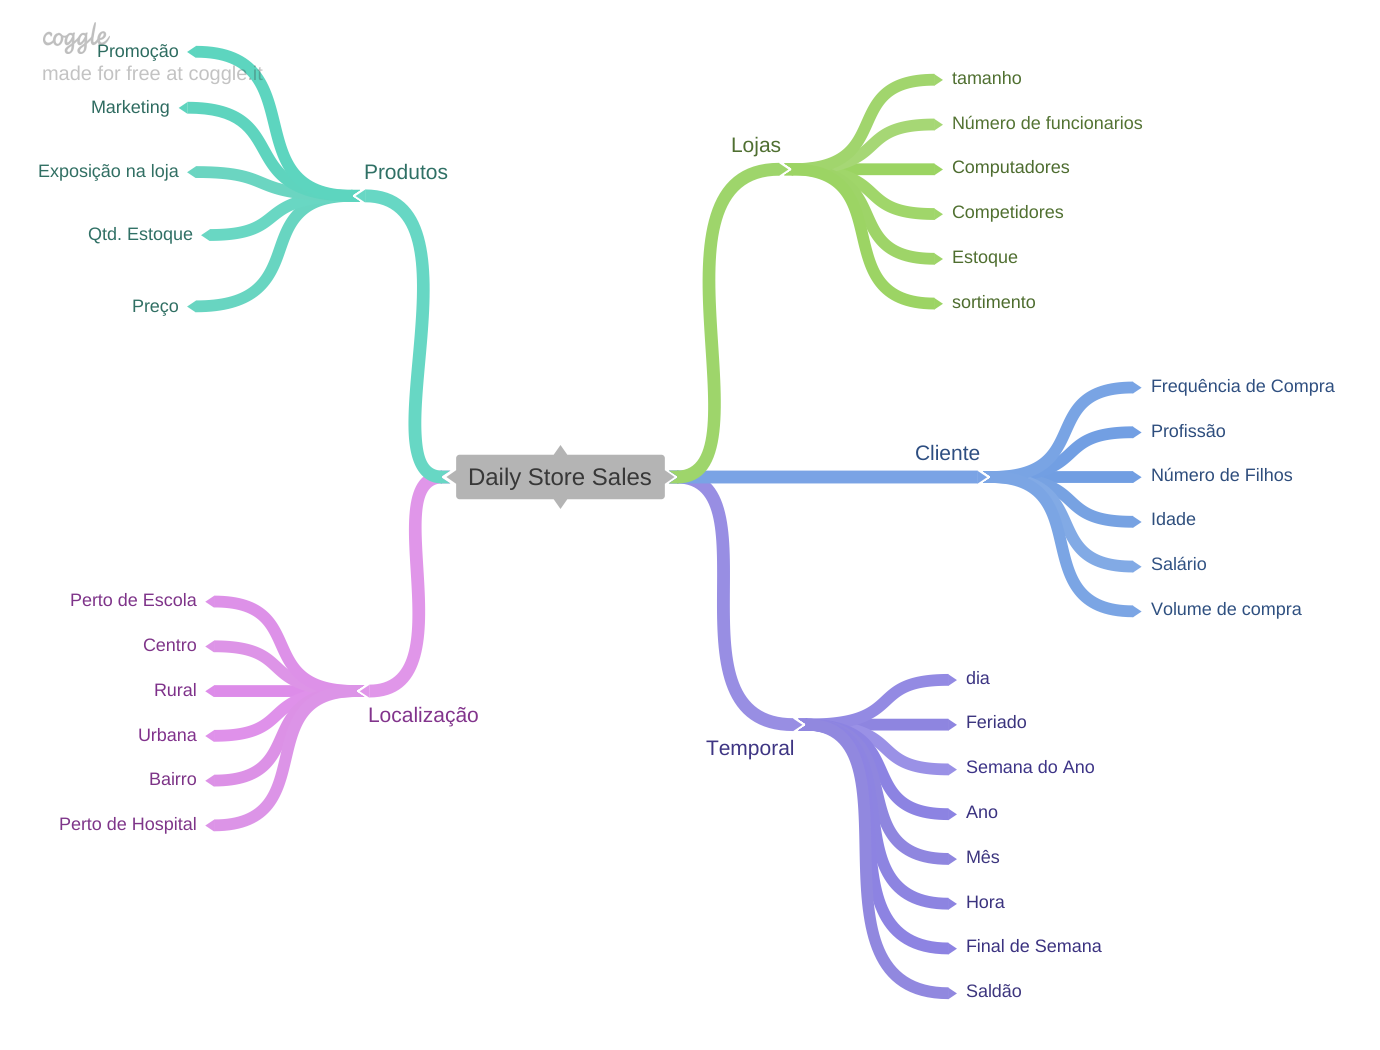

In [22]:
Image('img/Daily_Store_Sales.png')

## 2.2 Criação de Hipóteses

In [23]:
df2 = df1.copy()

### 2.2.1. Hipóteses da Loja

<ol>
    <li>Lojas com número maior de funcionários deveriam vender mais; </li>
    <li>Lojas com maior capacidade de estoque deveriam vender mais; </li>
    <li>Lojas de maior porte deveriam vender mais; </li>
    <li>Lojas com maior diversidade de produtos deveriam vender mais; </li>
    <li>Lojas com competidores mais próximos deveriam vender menos; </li>
    <li>Lojas com competidores de longa data deveriam vender mais; </li>
</ol>


### 2.2.2. Hipóteses do Produto

<ol>
    <li>Lojas que investem mais em marketng deveriam  vender mais;</li>
    <li>Lojas com maior exposição de produtos deveriam vender mais; </li>
    <li>Lojas com produtos de preços menores deveriam vender mais; </li>
    <li>Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais; </li>
    <li>Lojas com mais dias de promoção deveriam vender mais; </li>
    <li>Lojas com mais promoções consecutivas deveriam vender mais </li>
</ol>

### 2.2.3. Hipóteses Temporais

<ol>
    <li>Lojas abertas durante o feriado de natal deveriam vender mais</li>
    <li>Lojas deveriam vender mais ao longo dos anos; </li>
    <li>Lojas deveriam vender mais no segundo semestre do ano </li>
    <li>Lojas deveriam vender mais depois do dia 10 de cada mês </li>
    <li>Lojas deveriam vender menos aos finais de semana </li>
    <li>Lojas deveriam vender menos durante os feriados escolares </li>
</ol>

## 2.3. Lista Final de Hipóteses

<ol>
    <li>Lojas com maior diversidade de produtos deveriam vender mais; </li>
    <li>Lojas com competidores mais próximos deveriam vender menos; </li>
    <li>Lojas com competidores de longa data deveriam vender mais; </li>
    <li>Lojas com produtos de preços menores deveriam vender mais; </li>
    <li>Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais; </li>
    <li>Lojas com mais dias de promoção deveriam vender mais; </li>
    <li>Lojas com mais promoções consecutivas deveriam vender mais </li>
    <li>Lojas abertas durante o feriado de natal deveriam vender mais</li>
    <li>Lojas deveriam vender mais ao longo dos anos; </li>
    <li>Lojas deveriam vender mais no segundo semestre do ano </li>
    <li>Lojas deveriam vender mais depois do dia 10 de cada mês </li>
    <li>Lojas deveriam vender menos aos finais de semana </li>
    <li>Lojas deveriam vender menos durante os feriados escolares </li>
</ol>

## 2.3. Feature Engineering

In [24]:
#year
df2['year']= df2['date'].dt.year
#month
df2['month']= df2['date'].dt.month
#day
df2['day']= df2['date'].dt.day
#week of year
df2['week_of_year']= df2['date'].dt.isocalendar().week
df2['week_of_year']= df2['week_of_year'].astype('int64')
#year week
df2['year_week']= df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [26]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0. FILTRAING FEATURES

In [27]:
df3 = df2.copy()

### 3.1. Filtragem de linhas

Nessa setor eu vou colocar todas as variáveis que restrigem o negócio:
A exemplo: a variável 'open' será só 0 ou 1, 0 no caso de a loja estar fechada.
A segunda variável é a de 'sales' em que 0 significa: não houve venda.

In [28]:
df3 =df3[(df3['open'] !=0) & df3['sales']>0]

### 3.2. Seleção de Colunas

Nessa seleção de colunas eu posso retirar as que não vão mais gerar novas ideias ou insights de negócios. Sendo pq as ideias principais já foram retiradas dos dados contidos nela ou por que não são mais necessários

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis =1)

In [30]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
5,6,5,2015-07-31,5651,1,regular_day,1,a,basic,310.0,...,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
8,9,5,2015-07-31,8565,1,regular_day,1,a,extended,2030.0,...,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
9,10,5,2015-07-31,7185,1,regular_day,1,a,basic,3160.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


# 4.0. EXPLORATORY DATA ANALYSIS

In [31]:
df4=df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

Aqui eu estou olhando o comportamento da variável de resposta, porque, geralmente os algoratmos de machine larne utilizama  adistribuição de poason (distribuição normal) para fazer as correlações.

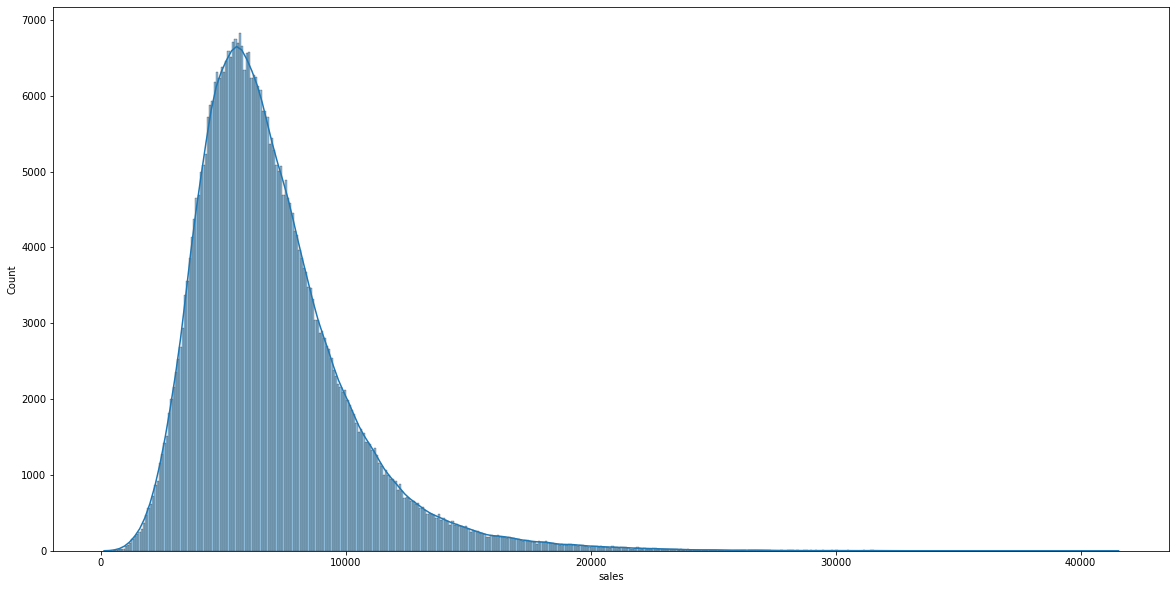

In [32]:
plt.figure(figsize=(20, 10))
sns.histplot(df4['sales'], kde=True);

### 4.1.2. Numerical Variable

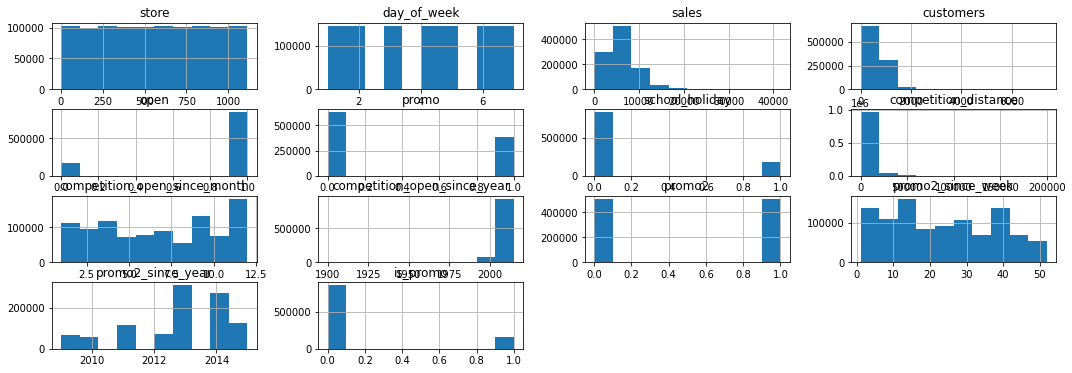

In [58]:
num_attributes.hist(figsize=(18,6));

### 4.1.3. Categorical Variable

Aqui é para tendar entender se vale a pena levar essas variáveis para o modelo, vendo se as variáveis têm informações relevantes para o modelo.

In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [35]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
273       extra
Name: assortment, dtype: object

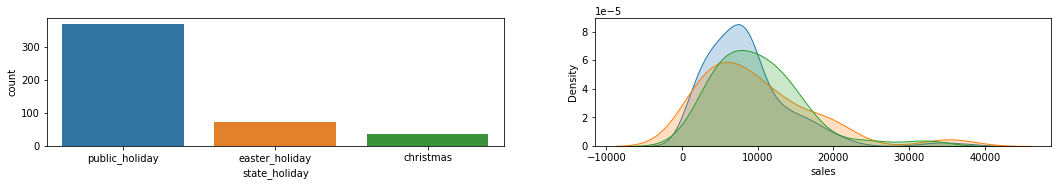

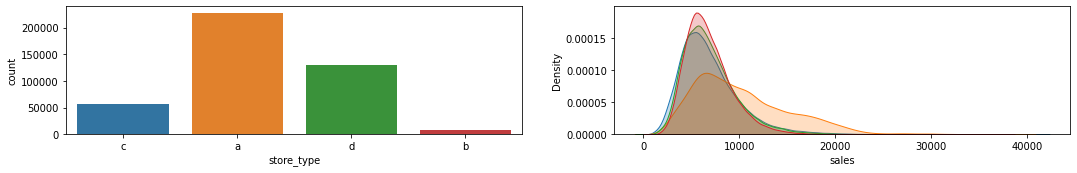

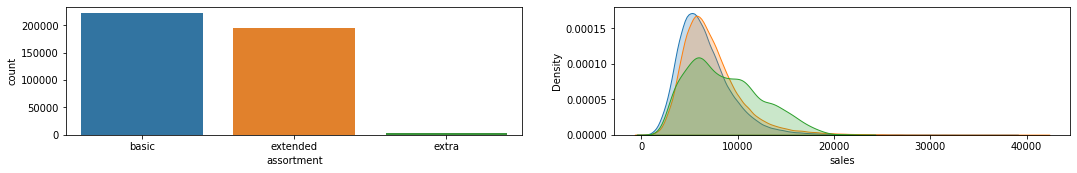

In [36]:
# state_holiday
df_holidays=df4[df4['state_holiday']!='regular_day']

plt.figure(figsize=(18, 8))
plt.subplot(3,2,1)
sns.countplot(x=df_holidays['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday',legend=True, shade=True);
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday',legend=True, shade=True);
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas', legend=True, shade=True);

#plt.subplot(3,,3)
#sns.kdeplot(data=df_holidays, x='sales', hue='state_holiday', palette='crest', shade=True)

# store_type
plt.figure(figsize=(18, 8))
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], shade=True,label='a', legend=True);
sns.kdeplot(df4[df4['store_type']=='b']['sales'], shade=True,label='b', legend=True);
sns.kdeplot(df4[df4['store_type']=='c']['sales'], shade=True,label='c', legend=True);
sns.kdeplot(df4[df4['store_type']=='d']['sales'], shade=True,label='d', legend=True);


# assortment
plt.figure(figsize=(18, 8))
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], shade=True, label='basic');
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], shade=True,label='extended');
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], shade=True, label='extra');

## 4.2. Análise Bivariada

### <b>H1.</b>Lojas com maior diversidade de produtos deveriam vender mais;
<b>FALSE.</b> O assortemt do type 'extra' é na realidade o que vende menos. Existe ma teoria no campo das vendas que diz que a quantidade de produos expostos ao mesmo tempo na realidade confunde o cliente, não o deixa confiante na compra.


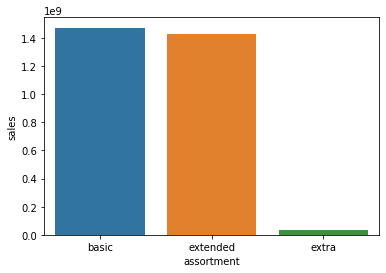

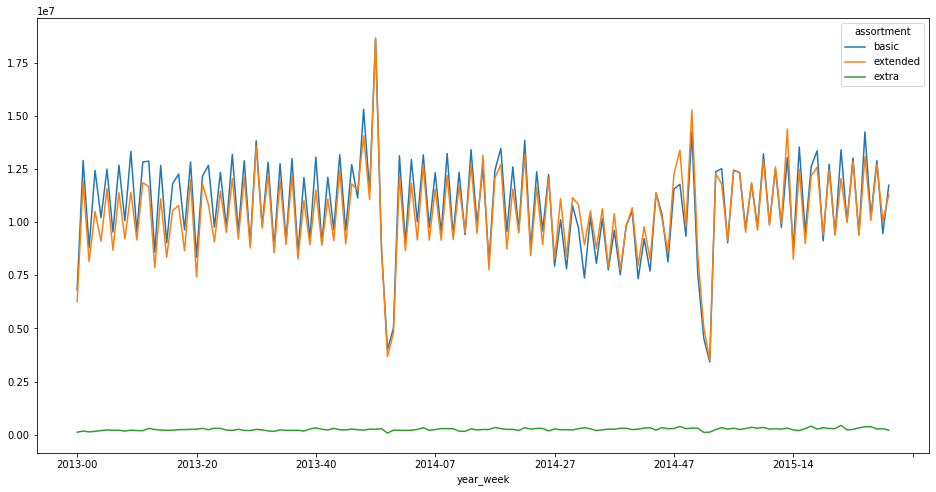

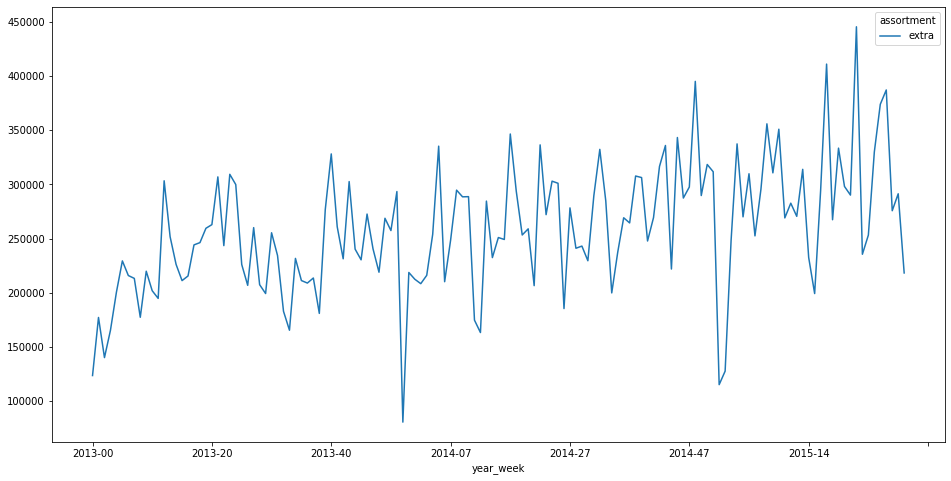

In [37]:
H1=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y='sales', data=H1);
# Para desvendar se essa variável tem uma tendência de tempo pode-se verificar qual se há alteração siginificativa 
#de acordo com o tempo

aux1 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index();

aux1.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,8));

#Devido à escala do extra ser bem menor que as demais então olhar com maiores detalhes para essa linha é uma opção
aux2=aux1[aux1['assortment']=='extra']

aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,8));

### <b>H2.</b>Lojas com competidores mais próximos deveriam vender menos;
<b>FALSE.</b> Lojas com competidores mais próximos vendem mais, com excessão das lojas que não tinha competidores plotados nos gráficos anteriores, o scatterplot deixa esse número em evidência.

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

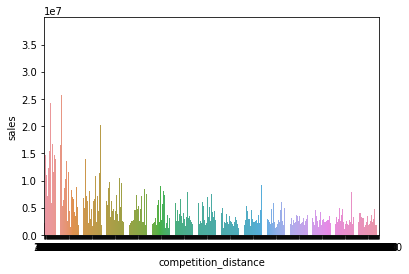

In [38]:
H2=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x='competition_distance',y='sales', data=H2)

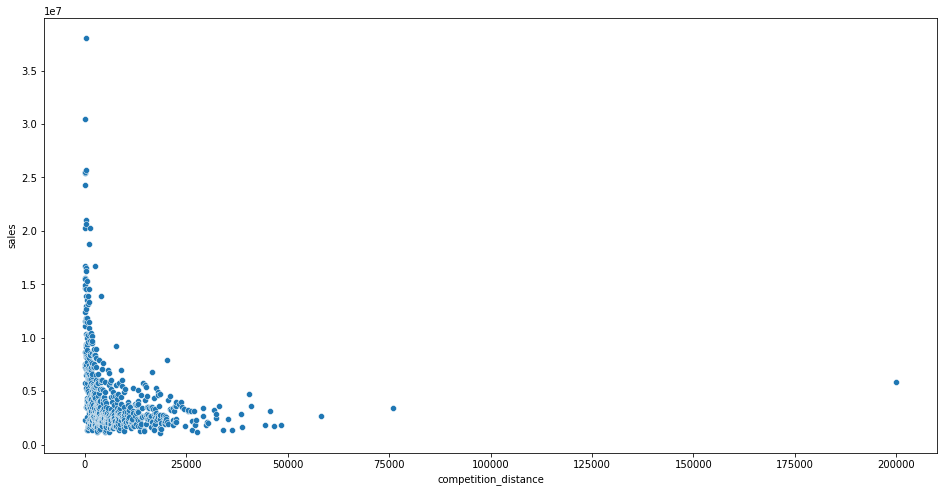

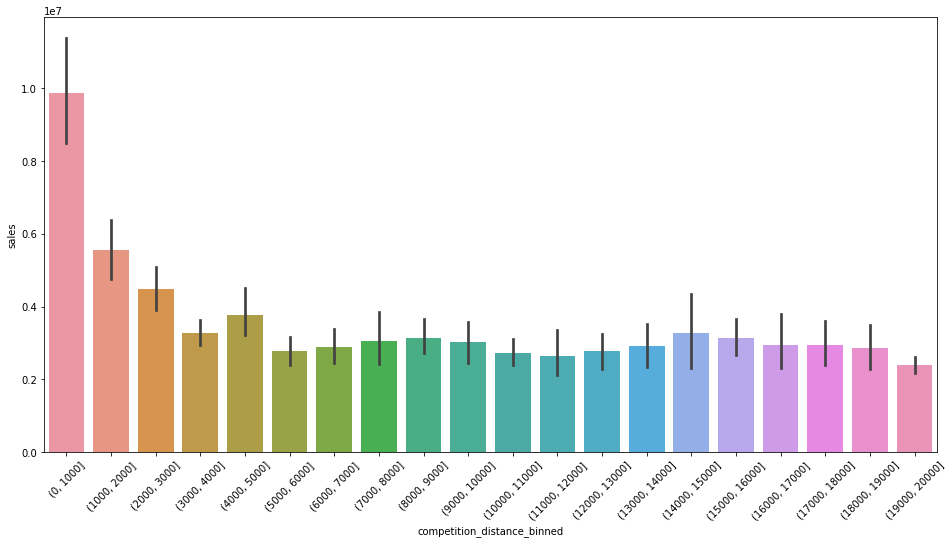

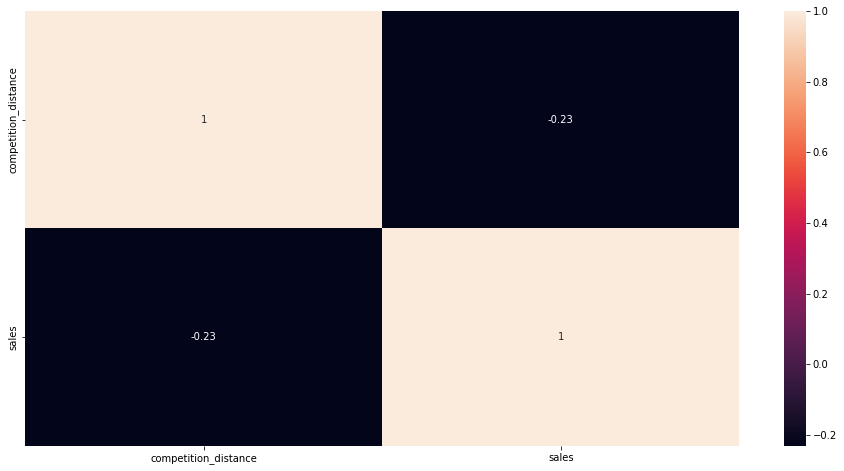

In [39]:
#Para validar melhor essa hipôtese é melhor criar grupos, vamos diminuir a granularidade dos dados junando em grupos de 1000 em 1000 metros de distância;
plt.figure(figsize=(16,8))
sns.scatterplot(x='competition_distance', y='sales', data=H2)

bins=list(np.arange(0,20001, 1000))
H2['competition_distance_binned']=pd.cut(H2['competition_distance'], bins=bins)
plt.figure(figsize=(16,8));
plt.xticks(rotation=45);
sns.barplot(x='competition_distance_binned', y='sales', data=H2);

#Olhando as correlações:
plt.figure(figsize=(16,8))
sns.heatmap(H2.corr(method='pearson'), annot=True);

#Existia um bug para ver as variáveis no meio, então caso ocorra novamente podemos realizar a seguinte prática:
# x = sns.hetmap(H2.corr(method='pearson'), annot=True);
# bottom, top = x.get_ylim()
# x.set_ylim(bottom+0.5, top-0.5);

### <b>H3.</b>Lojas com competidores de longa data deveriam vender mais;
<b>FALSE</b> Lojas com competidores que se consolidam vendem menos

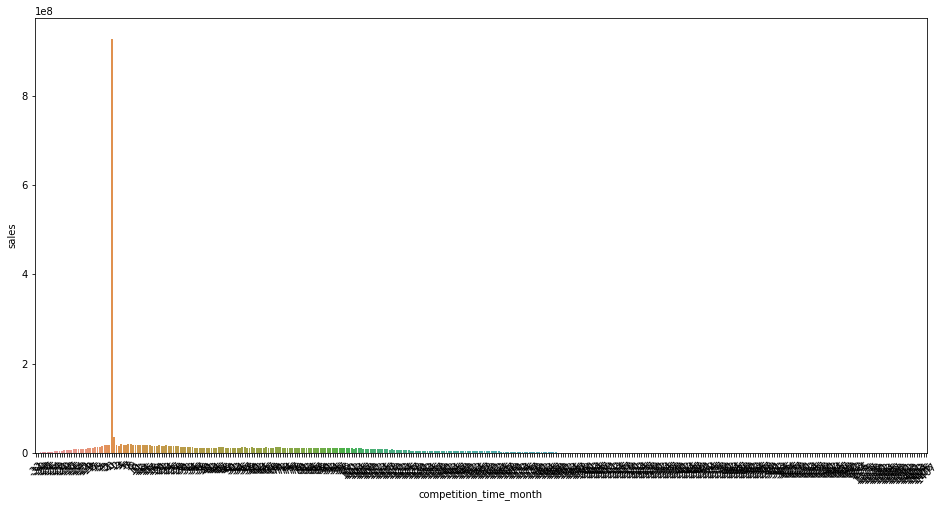

In [40]:
H3 =df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index();
plt.figure(figsize=(16,8))
sns.barplot(x='competition_time_month',y='sales', data=H3);
plt.xticks(rotation=45);

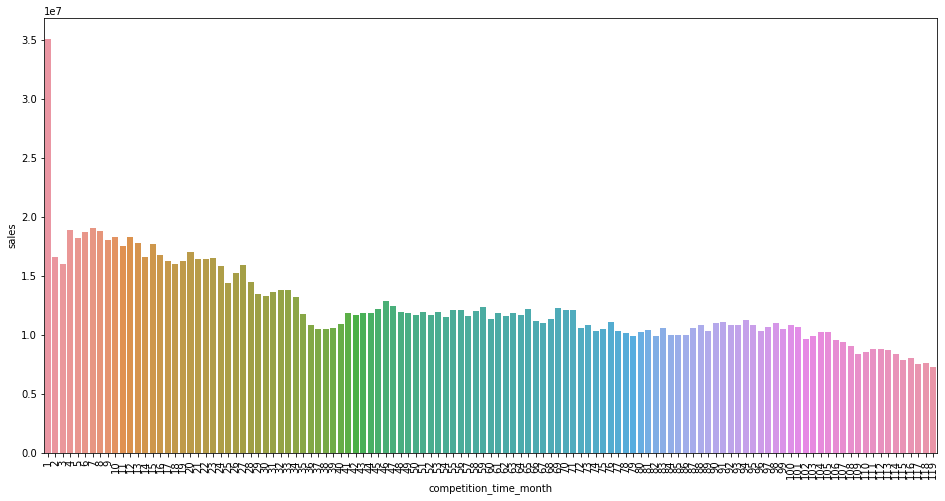

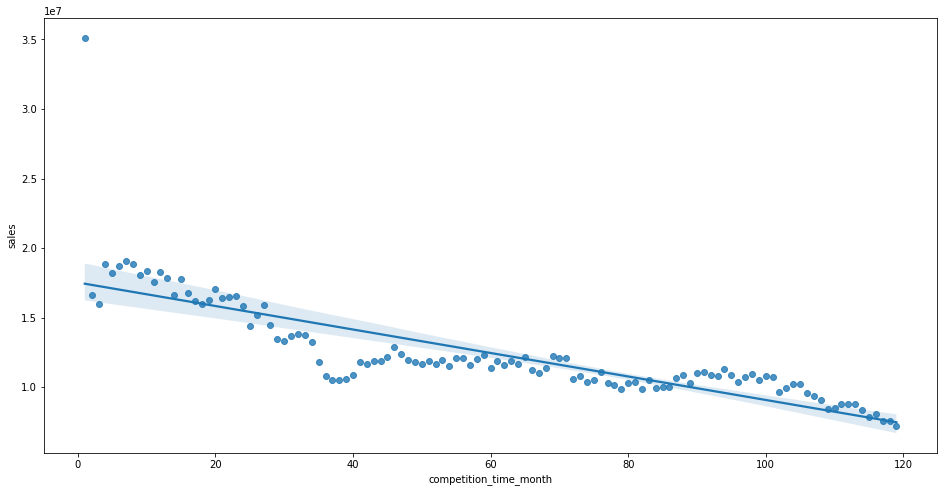

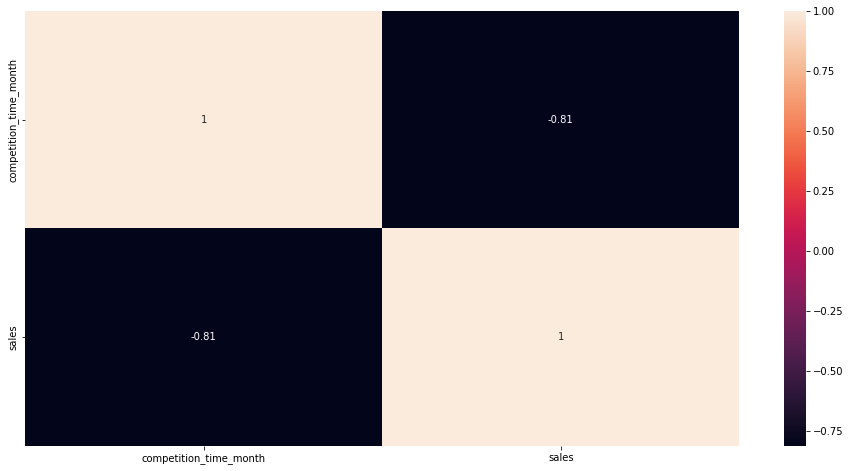

In [41]:
#Como temos uma resposta muito granular, assim como o gráfico passado devemos diminuir a granularidade ou filtrar as informações
#vê-se que a quantidade de informações tem váriáveis negativas, devido ao funcionamento dessa variável que foi derivada. 
#por isso, podemos retirar esses valores negativos das nossa informações

plt.figure(figsize=(16,8))
aux1=H3[(H3['competition_time_month']>0) & (H3['competition_time_month']<120)]
sns.barplot(x='competition_time_month',y='sales', data=aux1);
plt.xticks(rotation=90)


#Outro meios de verificar tendência, mas tendências lineares é:
plt.figure(figsize=(16,8))
sns.regplot(x='competition_time_month',y='sales',data=aux1);

#E o jeito tradicional é:
plt.figure(figsize=(16,8))
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <b>H4.</b>Lojas com promoções à mais tempo deveriam vender mais;
<b>FALSE.</b>Lojas com promoções à mais tempo vendem menos, pode ser devido ao fato de os clientes se acostumarem as promoções.

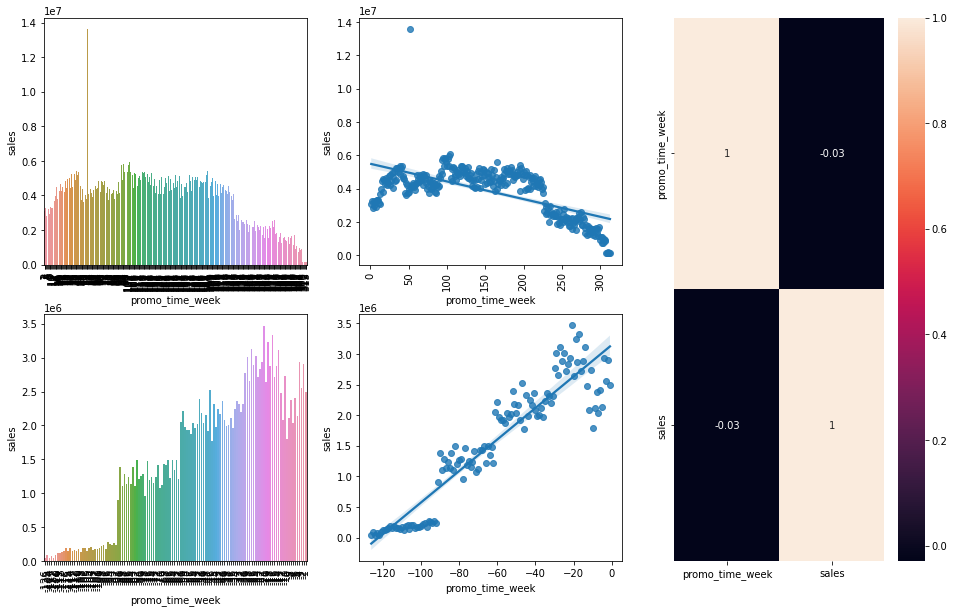

In [42]:
H4 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux1_h4 = H4[H4['promo_time_week']>0] #Promoção extendida
plt.figure(figsize=(16,10))

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux1_h4);
plt.xticks(rotation=90);


plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux1_h4);
plt.xticks(rotation=90);

aux2_h4 = H4[H4['promo_time_week']<0] #Promoção regular
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2_h4);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2_h4);

plt.subplot(grid[:,2])
sns.heatmap(H4.corr(method='pearson'), annot=True);

### <s><b>H5.</b>Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais</s>

### <b>H6.</b>Lojas com mais dias de promoção deveriam vender mais
<b>FALSE</b> Essa hipótese já foi validada anteriormente

### <b>H7.</b>Lojas com mais promoções consecutivas deveriam vender mais
<b>FALSE.</b> As lojas com a promoção extendidas na verdade venderam menos depois de um certo período

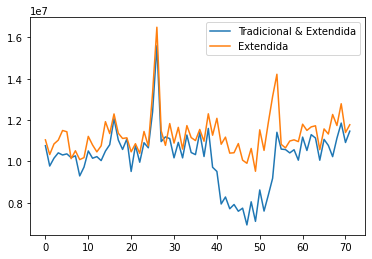

In [43]:
H7=df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

aux1_h7 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
h7_graf7 = aux1_h7.plot();

aux2_h7 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2_h7.plot(ax=h7_graf7);

h7_graf7.legend(labels=["Tradicional & Extendida", "Extendida"]);

### <b>H8.</b>Lojas abertas durante o feriado de natal deveriam vender mais
<b>FALSO</b> O Natal é o feriado com menor número de vendas.

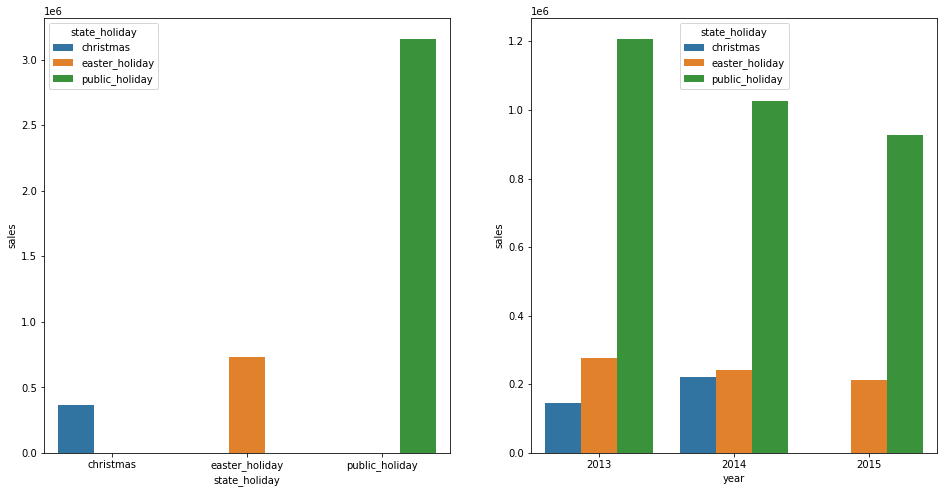

In [44]:
H8 = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
H8 = H8[H8['state_holiday']!='regular_day']
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', hue='state_holiday', data=H8);

aux_h8 = df4[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
aux_h8 = aux_h8[aux_h8['state_holiday']!='regular_day']
plt.subplot(1,2,2);
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux_h8);

### <b>H9.</b>Lojas deveriam vender mais ao longo dos anos

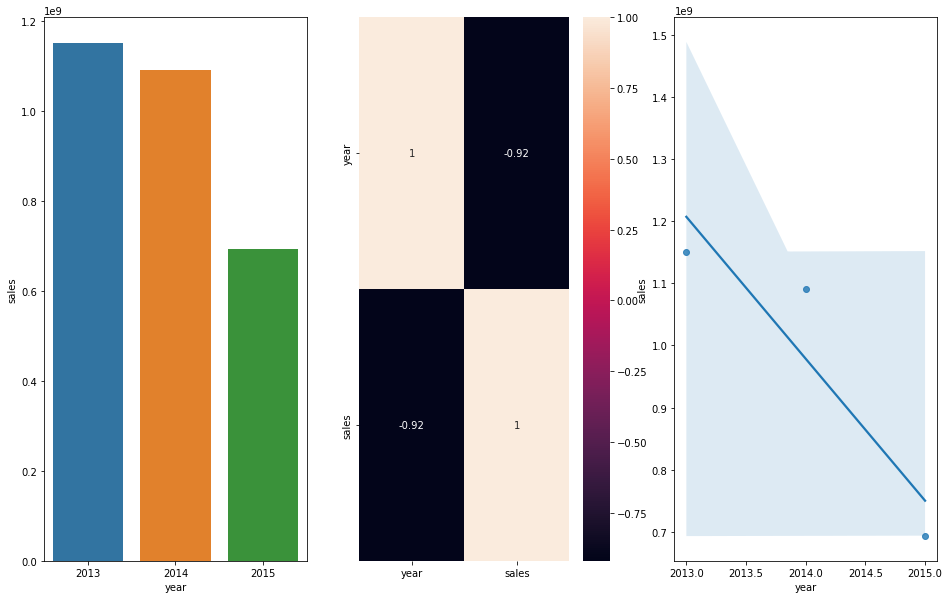

In [45]:
H9=df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(16,10))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=H9);
plt.subplot(1,3,2)
sns.heatmap(H9.corr(method='pearson'), annot=True);
plt.subplot(1,3,3)
sns.regplot(x='year', y='sales', data=H9);

### <b>H10.</b>Lojas deveriam vender mais no segundo semestre do ano

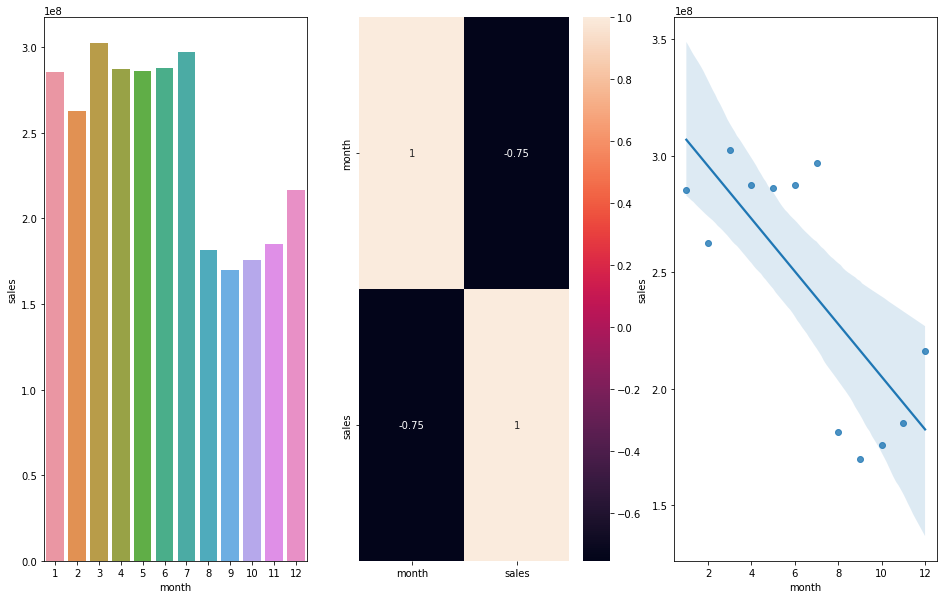

In [46]:
H10=df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(16,10))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=H10);
plt.subplot(1,3,2)
sns.heatmap(H10.corr(method='pearson'), annot=True);
plt.subplot(1,3,3)
sns.regplot(x='month', y='sales', data=H10);

### <b>H11.</b>Lojas deveriam vender mais depois do dia 10 de cada mês

In [47]:
H11 = df4[['day', 'sales']]
H11["before_or_after"] = df4['day'].apply(lambda x: 'before' if x<=10 else 'after')
H11

C:\Users\User\AppData\Local\Temp\ipykernel_19048\1545048511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H11["before_or_after"] = df4['day'].apply(lambda x: 'before' if x<=10 else 'after')


,day,sales,before_or_after
0,31,5263,after
3,31,13995,after
5,31,5651,after
8,31,8565,after
9,31,7185,after
...,...,...,...
1016776,1,3375,before
1016827,1,10765,before
1016863,1,5035,before
1017042,1,4491,before


### <b>H12.</b>Lojas deveriam vender menos aos finais de semana

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

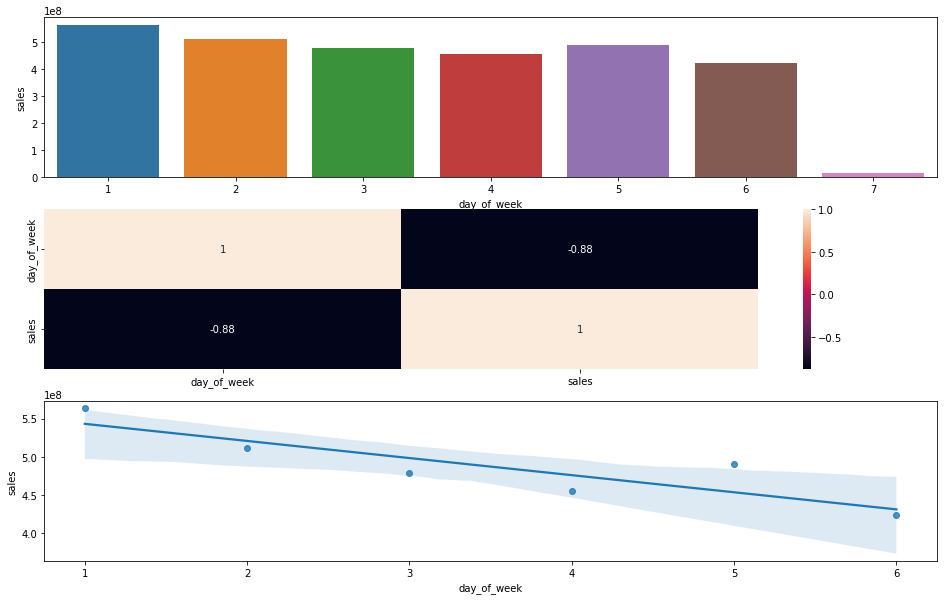

In [48]:
H12 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize=(16,10))

plt.subplot(3,1,1)
sns.barplot(x='day_of_week', y='sales', data=H12)

aux1=H12[H12['day_of_week']!=7]
plt.subplot(3,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(3,1,3)
sns.regplot(x='day_of_week', y='sales', data=aux1)

### <b>H13.</b>Lojas deveriam vender menos durante os feriados escolares

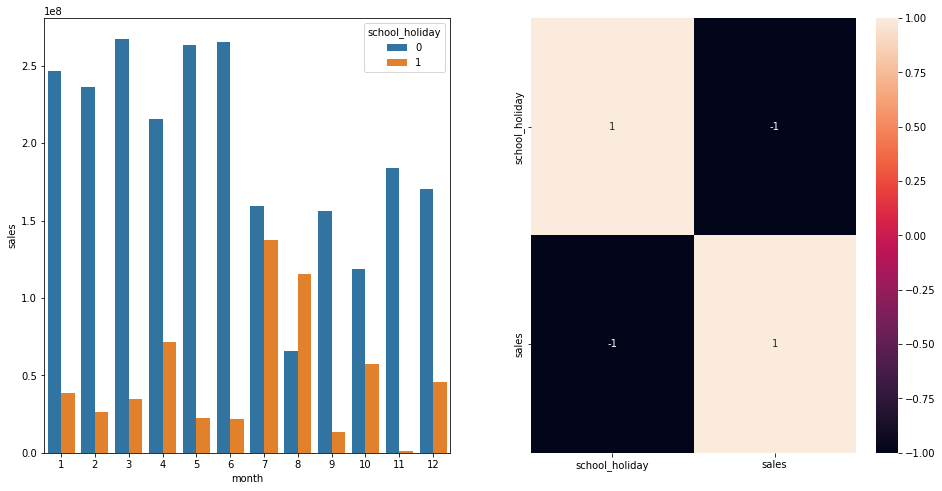

In [49]:
H13 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
aux2 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.barplot(x='month', y='sales', hue='school_holiday', data=H13);

plt.subplot(1,2,2)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

## 4.3. Análise Multivariada

### 4.3.1. Análise Numérica

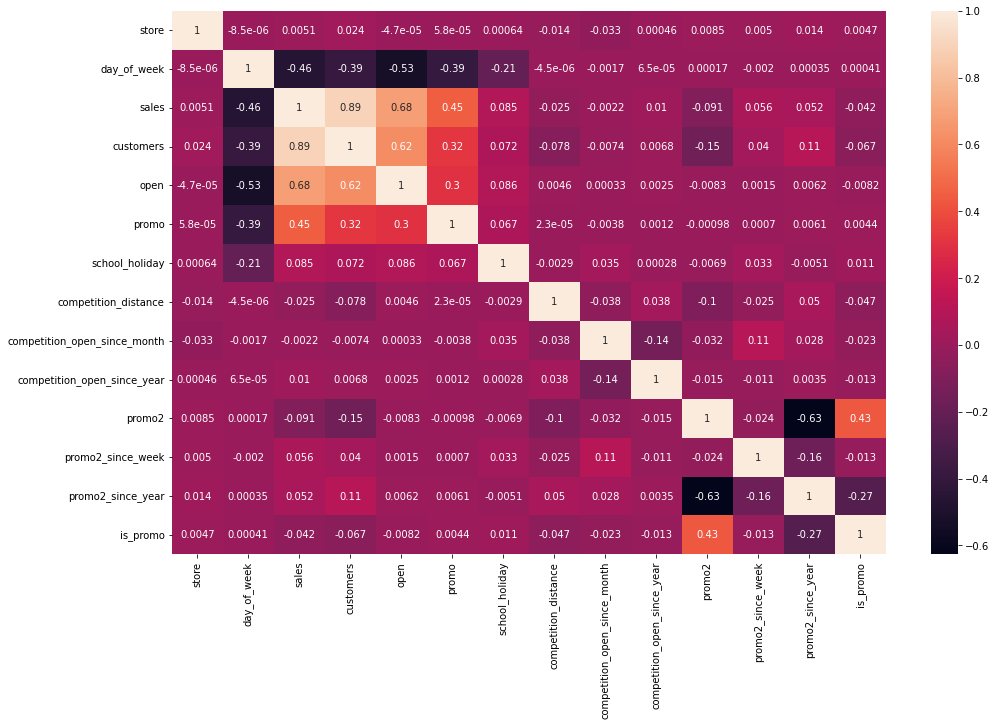

In [50]:
correlation = num_attributes.corr(method='pearson');
plt.figure(figsize=(16, 10))
sns.heatmap(correlation, annot=True);

### 4.3.2. Análise Categórica

<AxesSubplot:>

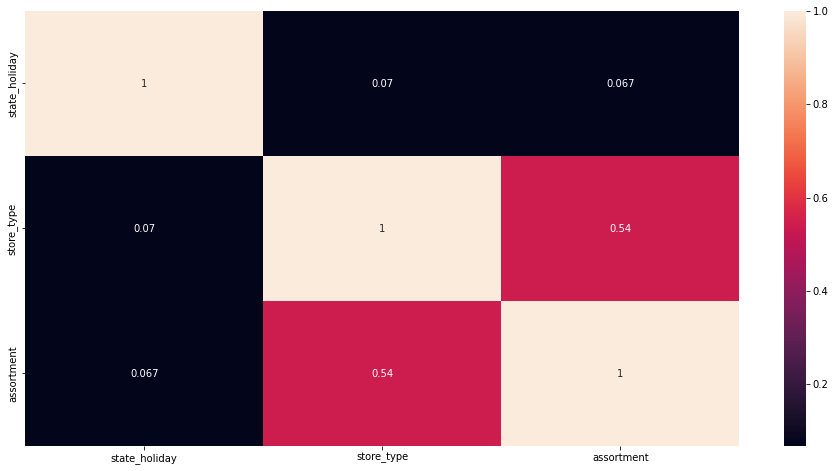

In [51]:
#cat_attributes is outdated so to update the information we can to creat a variable from df4

cat_attributes_updated = df4.select_dtypes(include="object")
cat_attributes_updated = cat_attributes_updated.drop('year_week', axis='columns')

# calculting crames'v:
a1 = cramer_v(cat_attributes_updated['state_holiday'], cat_attributes_updated['state_holiday'])
a2 = cramer_v(cat_attributes_updated['state_holiday'], cat_attributes_updated['store_type'])
a3 = cramer_v(cat_attributes_updated['state_holiday'], cat_attributes_updated['assortment'])

a4 = cramer_v(cat_attributes_updated['store_type'], cat_attributes_updated['state_holiday'])
a5 = cramer_v(cat_attributes_updated['store_type'], cat_attributes_updated['store_type'])
a6 = cramer_v(cat_attributes_updated['store_type'], cat_attributes_updated['assortment'])

a7 = cramer_v(cat_attributes_updated['assortment'], cat_attributes_updated['state_holiday'])
a8 = cramer_v(cat_attributes_updated['assortment'], cat_attributes_updated['store_type'])
a9 = cramer_v(cat_attributes_updated['assortment'], cat_attributes_updated['assortment'])

#Createing a dataframe with anwsers:
cramer_df = pd.DataFrame({'state_holiday':[a1,a2,a3],
                              'store_type':[a4,a5,a6],
                              'assortment':[a7,a8,a9]})
cramer_df.index=cramer_df.columns

# Heat map to do it more visual:
plt.figure(figsize=(16,8))
sns.heatmap(cramer_df, annot=True)

# 5.0. DATA PREPARATION

In [123]:
df5 = df4.copy()

## 5.1. Normalization

In [124]:
# It don't have any variable with normal distribution

## 5.2. Rescaling

In [125]:
a = df5.select_dtypes(include=['float64', 'int64'])

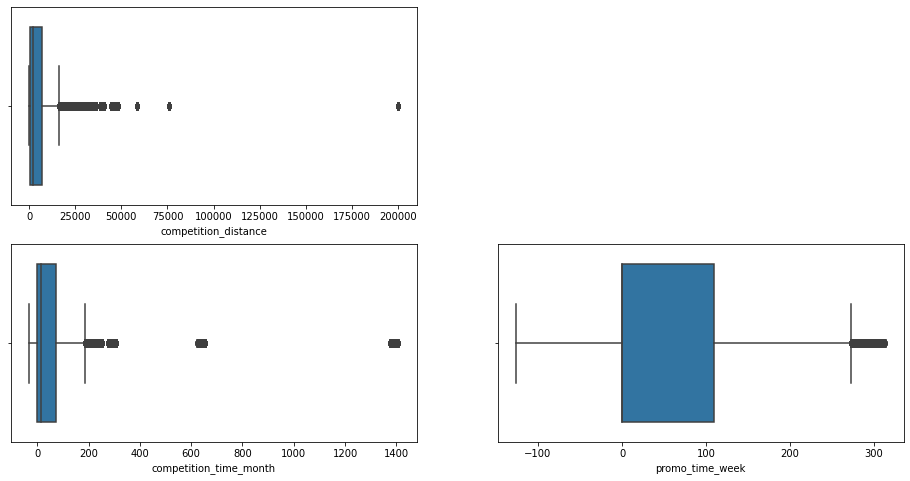

In [126]:
grid = GridSpec(2, 2)

plt.figure(figsize=(16,8))
plt.subplot(grid[0,0])
sns.boxplot(x='competition_distance', data=a);
plt.subplot(grid[1,0])
sns.boxplot(x='competition_time_month', data=a);
plt.subplot(grid[1,1])
sns.boxplot(x='promo_time_week', data=a);

In [127]:
rs =RobustScaler()
mms=MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = mms.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = rs.fit_transform(df5[['promo_time_week']].values)

# year 
df5['year']=mms.fit_transform(df5[['year']].values)

## 5.3. Transformation

### 5.3.1. Enconding

In [128]:
#state_holiday
df5=pd.get_dummies(df5,prefix=['state_hoiliday'], columns=['state_holiday'])

#store_type
le=LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment
assort_dict={'basic':1, 'extra':2, 'extended':3}
df5['assortment']=df5['assortment'].map(assort_dict)

### 5.3.2. Response Variable Transformation

In [129]:
df5['sales'] = np.log1p(df5['sales'])

<Figure size 1152x576 with 0 Axes>

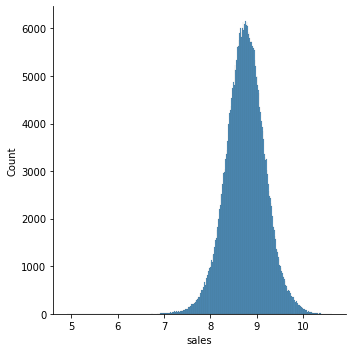

In [130]:
plt.figure(figsize=(16,8))
sns.displot(df5['sales']);

In [131]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_hoiliday_christmas,state_hoiliday_easter_holiday,state_hoiliday_public_holiday,state_hoiliday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.080612,2015-07-27,0.0,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.071577,2015-07-27,0.0,0,0,0,1
5,6,5,2015-07-31,8.639765,1,1,0,1,-0.325806,12,...,31,2015-30,2013-12-01,0.036136,2015-07-27,0.0,0,0,0,1
8,9,5,2015-07-31,9.055556,1,1,0,3,-0.048387,8,...,31,2015-30,2000-08-01,0.148714,2015-07-27,0.0,0,0,0,1
9,10,5,2015-07-31,8.879890,1,1,0,1,0.133871,9,...,31,2015-30,2009-09-01,0.071577,2015-07-27,0.0,0,0,0,1


In [132]:
# day of week
df5['day_of_week'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*(np.pi/7))))
df5['day_of_week'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*(np.pi/7))))
                                            
# month
df5['month']=df5['month'].apply(lambda x: np.sin(x*(2.*(np.pi/12))))
df5['month']=df5['month'].apply(lambda x: np.cos(x*(2.*(np.pi/12))))

# day
df5['day']=df5['day'].apply(lambda x: np.sin(x*(2.*(np.pi/30))))
df5['day']=df5['day'].apply(lambda x: np.cos(x*(2.*(np.pi/30))) )                              

# week of year
df5['week_of_year']=df5['week_of_year'].apply(lambda x: np.sin(x*(2.*(np.pi/52))))
df5['week_of_year']=df5['week_of_year'].apply(lambda x: np.cos(x*(2.*(np.pi/52))))


In [133]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_hoiliday_christmas,state_hoiliday_easter_holiday,state_hoiliday_public_holiday,state_hoiliday_regular_day
0,1,0.640925,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0.997645,2015-30,2008-09-01,0.080612,2015-07-27,0.0,0,0,0,1
3,4,0.640925,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0.997645,2015-30,2009-09-01,0.071577,2015-07-27,0.0,0,0,0,1
5,6,0.640925,2015-07-31,8.639765,1,1,0,1,-0.325806,12,...,0.997645,2015-30,2013-12-01,0.036136,2015-07-27,0.0,0,0,0,1
8,9,0.640925,2015-07-31,9.055556,1,1,0,3,-0.048387,8,...,0.997645,2015-30,2000-08-01,0.148714,2015-07-27,0.0,0,0,0,1
9,10,0.640925,2015-07-31,8.879890,1,1,0,1,0.133871,9,...,0.997645,2015-30,2009-09-01,0.071577,2015-07-27,0.0,0,0,0,1
